In [1]:
from __future__ import print_function, division

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess
from climlab.utils import heat_capacity
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model
import plotting
import cmocean


/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# read in datasets

In [3]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
run_name = 'normal'


month_ds_dict = {} 

for month in months: 
    month_ds_dict[month] = xr.open_dataset(f'../output/{month}_{run_name}_ds')

# Define constants

In [68]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076

times = month_ds_dict[month].time.values
color_map = [
    [6.72862e-01, 1.39087e-01, 2.69400e-03],
    [5.08815e-01, 0.00000e+00, 0.00000e+00],
    [2.99417e-01, 3.66000e-04, 5.48000e-04],
    [0.00000e+00, 0.00000e+00, 6.00000e-06],
    [0.00000e+00, 1.20401e-01, 3.02675e-01],
    [0.00000e+00, 2.16583e-01, 5.24574e-01],
    [1.28047e-01, 4.92588e-01, 7.20288e-01],
    [1.88955e-01, 6.41309e-01, 7.92092e-01],
    [6.08240e-01, 8.92164e-01, 9.35547e-01],
    [9.04481e-01, 6.90489e-01, 0.00000e+00],
    [8.54070e-01, 5.10864e-01, 0.00000e+00],
    [7.77093e-01, 3.30180e-01, 8.82000e-04]
] #modified from Paraview's erdc_iceFire

# Column Temperature Difference (Doubled-Base)

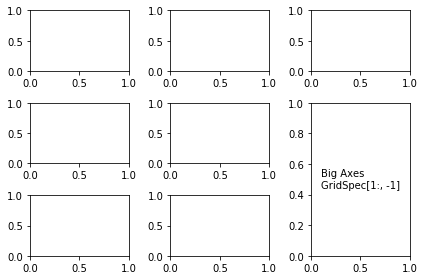

In [142]:
fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(3, 3)
f3_ax1 = fig3.add_subplot(gs[0, :])
f3_ax1.set_title('gs[0, :]')
f3_ax2 = fig3.add_subplot(gs[1, :-1])
f3_ax2.set_title('gs[1, :-1]')
f3_ax3 = fig3.add_subplot(gs[1:, -1])
f3_ax3.set_title('gs[1:, -1]')
f3_ax4 = fig3.add_subplot(gs[-1, 0])
f3_ax4.set_title('gs[-1, 0]')
f3_ax5 = fig3.add_subplot(gs[-1, -2])
f3_ax5.set_title('gs[-1, -2]')

/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

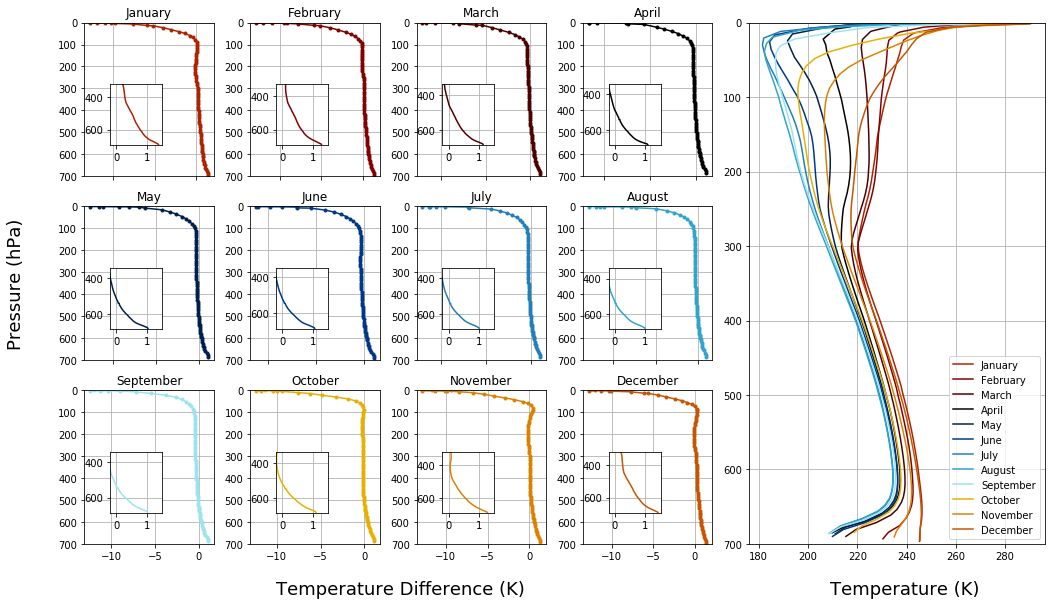

In [232]:
t = times[-1]

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

color = iter(color_map)

fig = plt.figure(figsize = (14,8))
gs = fig.add_gridspec(3,6)
for idx, month in enumerate(months):
    c = next(color)
    ax = fig.add_subplot(gs[idx//4, np.mod(idx,4)])
    x1 = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1, time = t)['T']
    x2 = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc2, time = t)['T']
    y =  month_ds_dict[month].lev_full
    ax.plot(x2-x1, y, marker = '.', label = 'Temperature', c = c)
    ax.set_title(month)
    ax.set_ylim(700,0)
    ax.grid(True)
    if idx <= 7:
        ax.xaxis.set_ticklabels([])
    
    
    #inset axes
    axins = ax.inset_axes([.2,.2, .4,.4])
    axins.plot((x2-x1)[-40:], y[-40:], c = c)
    axins.set_ylim(y[-40:].max(),y[-40:].min())
    axins.set_xlim(-.2,1.5)
    axins.grid(True)
    
    #add in the temperature profile
    x = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1, time = times[0])['T']
    y =  month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1)['lev_full']
    ax_temp = fig.add_subplot(gs[:, -2:])
    ax_temp.plot(x, y, label = month, color = c)
    ax_temp.set_ylabel('')
    ax_temp.set_xlabel('')
    ax_temp.set_title(month)
    ax_temp.set_ylim(700,0)
    ax_temp.grid(True)
    ax_temp.set_title('')
    ax_temp.legend()
    
plt.tight_layout()
fig.text(0.35, -0.04, 'Temperature Difference (K)', ha='center', fontsize = 18)
fig.text(0.85, -0.04, 'Temperature (K)', ha='center', fontsize = 18)
fig.text(-0.04, 0.5, 'Pressure (hPa)', va='center', rotation='vertical', fontsize = 18)
#plt.suptitle(r'Temperature Difference (Double CO$_2$-Base CO$_2$)',fontsize = 20, y = 1.03);
plt.savefig('../figures/temp_dif.png', dpi = 150, bbox_inches = 'tight')

# Surface CO2 Effect

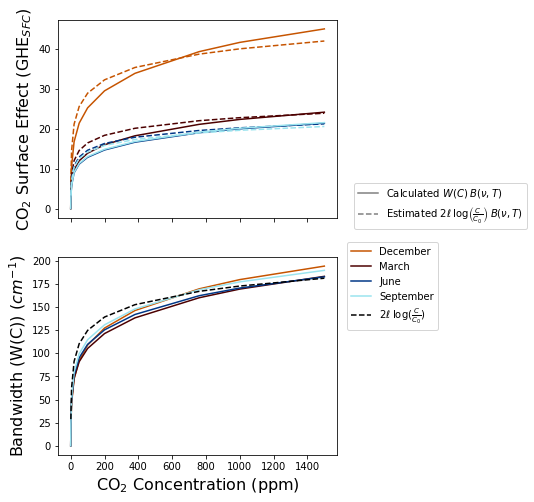

In [75]:
colors_dict = {'December':color_map[11],'March':color_map[2], 'June':color_map[5], 'September':color_map[8]}
ppm_convert = 1e6

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(5,8))
for month in colors_dict.keys():
    c = colors_dict[month]
    
#### plot our co2 surface effect ####
    x = month_ds_dict[month].co2_lev *ppm_convert
    y = month_ds_dict[month]['sfc_co2_effect']
    ax1.plot(x,y,
        label = month, 
        color = c)
    #plt.xscale('log')
    ax1.plot(x, month_ds_dict[month]['sfc_co2_estimate'],
        color = c, linestyle = '--')

#### plot our effective bandwidth ####
    x = month_ds_dict[month].co2_lev *ppm_convert
    y = month_ds_dict[month]['eff_bandwidth']
    ax2.plot(x,y,
        label = month, 
        color = c)
    #plt.xscale('log')
ax2.plot(x[1:], month_ds_dict[month]['eff_bandwidth_est'],
            label = r'$2 \ell  \; \log(\frac{C}{C_0})$',
        color = 'k', linestyle = '--')

ax2.set_xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
ax2.set_ylabel(r'Bandwidth (W(C)) ($cm^{-1}$)', fontsize = 16)
ax2.legend(bbox_to_anchor = [1.38, 1.1]);

#ax1.set_xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
ax1.set_ylabel(r'CO$_2$ Surface Effect (GHE$_{SFC})$', fontsize = 16)

line = Line2D([0,1],[0,1],linestyle='-', color='grey')
dots = Line2D([0,1],[0,1],linestyle='--', color='grey')

ax1.legend([line, dots],[r'Calculated $W(C) \; B(\nu, T)$',r'Estimated $2 \ell \; \log\left(\frac{C}{C_0}\right) \; B(\nu, T)$ '], bbox_to_anchor = [1.7, 0.2])
#plt.savefig('../figures/sfc_bandwidth_and_co2.png', dpi = 150, bbox_inches = 'tight')

# GHE (Surface and TOA)

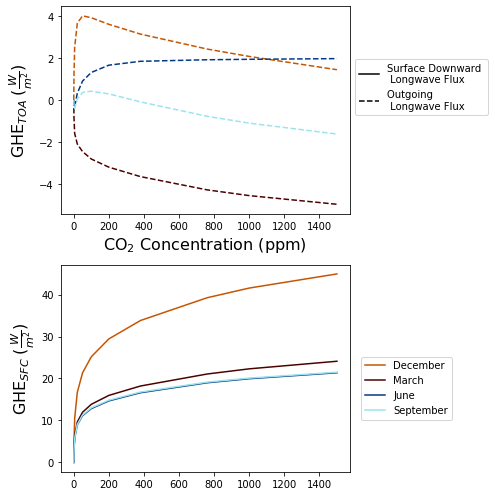

In [74]:
cmap = cmocean.cm.thermal(np.linspace(0,1,len(months)+1))
colors_dict = {'December':color_map[11],'March':color_map[2], 'June':color_map[5], 'September':color_map[8], 'January':color_map[0], 'February':color_map[1], 'November':color_map[9]}

fig, (ax2,ax1) = plt.subplots(2,1, figsize = (7,7))
for month in ['December','March','June','September']:
    c = colors_dict[month]
    #GHE SFC plot
    x = month_ds_dict[month].co2_lev *1e6
    y = month_ds_dict[month]['sfc_co2_effect']
    ax1.plot(x,y,
        label = month, 
        color = c)
    #GHE TOA plot
    x = month_ds_dict[month].co2_lev *1e6
    y = (month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = 0)['LW_flux_net_clr'] - 
     month_ds_dict[month].sel(time = 0, model = 'rat').isel(lev_bounds = 0)['LW_flux_net_clr'])
    ax2.plot(x, y,
            label = month, 
             color = c, 
             linestyle = '--')
    
#set up labels
ax1.set_ylabel(r'GHE$_{SFC}\; (\frac{W}{m^2})$', fontsize = 16)
ax2.set_xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
ax2.set_ylabel(r'GHE$_{TOA}\; (\frac{W}{m^2})$', fontsize = 16)

#set up legends
ax1.legend(bbox_to_anchor = [1.37, 0.58]);

line = Line2D([0,1],[0,1],linestyle='-', color='k')
dots = Line2D([0,1],[0,1],linestyle='--', color='k')

ax2.legend([line, dots],['Surface Downward \n Longwave Flux','Outgoing \n Longwave Flux'], bbox_to_anchor = [1., 0.77])
plt.tight_layout()
#plt.savefig('../figures/GH_sfc_CO2_effect.png', dpi = 150, bbox_inches = 'tight')


### Calculate if the dGHE/dCO2 is positive or negative

negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect
negative value in TOA CO2 Effect


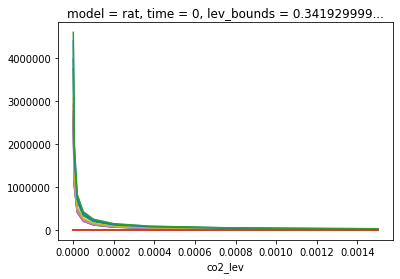

In [40]:
for month in months:
    (month_ds_dict[month]['sfc_co2_effect']/month_ds_dict[month].co2_lev).plot()
    #print a warning if any are less than 0
    if ((month_ds_dict[month]['sfc_co2_effect']/month_ds_dict[month].co2_lev) < 0).any()<0:
        print('negative value in SFC CO2 Effect')
    ((month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = 0)['LW_flux_net_clr'] - 
     month_ds_dict[month].sel(time = 0, model = 'rat').isel(lev_bounds = 0)['LW_flux_net_clr'])/(month_ds_dict[month].co2_lev*1e6)).plot()
    #print a warning if any are less than 0
    if (((month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = 0)['LW_flux_net_clr'] - 
     month_ds_dict[month].sel(time = 0, model = 'rat').isel(lev_bounds = 0)['LW_flux_net_clr'])/(month_ds_dict[month].co2_lev*1e6)) < 0).any():
        print('negative value in TOA CO2 Effect')

# Surface Temperature

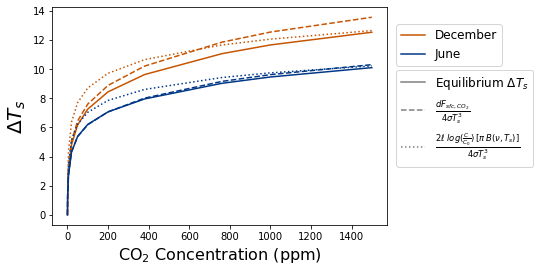

In [73]:
fig, ax1 = plt.subplots()
plot_lines = []
for month in ['December','June']:
    c = colors_dict[month]
    #plot the calculated sfc co2 effect dTs
    y = month_ds_dict[month]['sfc_co2_effect']/(4*5.6E-8*month_ds_dict[month]['T'].isel(lev_full = -1, time = 0).sel(model = 'rat')**3)
    x = month_ds_dict[month]['co2_lev']*ppm_convert
    plot1 = plt.plot(x, y, label = month, linestyle = '--', color = c)
    #plot the model dTs
    y = (month_ds_dict[month]['T'].isel(lev_full = -1, time = -1).sel(model = 'rat')- 
     month_ds_dict[month]['T'].isel(lev_full = -1, time = -1).sel(model = 'rat', co2_lev = 0))
    plot2 = plt.plot(x, y, label = month, linestyle = '-', color = c)
    #plot the estimated sfc co2 effect dTs
    y = month_ds_dict[month]['sfc_co2_estimate']/(4*5.6E-8*month_ds_dict[month]['T'].isel(lev_full = -1, time = 0).sel(model = 'rat')**3)
    plot3 = plt.plot(x, y, label = month, linestyle = ':', color = c)
    #labels
    plt.ylabel(r'$\Delta T_s$', fontsize = 20)
    plt.xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
    plot_lines.append(plot2)
#legends
line = Line2D([0,1],[0,1],linestyle='-', color='grey')
dash = Line2D([0,1],[0,1],linestyle='--', color='grey')
dot =  Line2D([0,1],[0,1],linestyle=':', color='grey')
legend1 = plt.legend([line, dash, dot],[r'Equilibrium $\Delta T_s$',
                                         r'$\frac{dF_{sfc,CO_2}}{4\sigma T_s^3}$', 
                                         r'$\frac{2 \ell \ log(\frac{C}{C_0})\:[\pi\, B(\nu, T_s)]}{4\sigma T_s^3}$'], fontsize = 12, bbox_to_anchor = [1.01, 0.74])
plt.legend([l[0] for l in plot_lines], ['December','June'], fontsize = 12, bbox_to_anchor = [1.01, 0.95])
plt.gca().add_artist(legend1)

#plt.savefig('../figures/delta_Ts.png', dpi = 150, bbox_inches = 'tight')
